In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!unzip -qq "/content/drive/Othercomputers/My Laptop/Documents/Thị giác máy tính/Final_project/data.zip" -d /content/

In [ ]:
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'

In [ ]:
for dir_name in [train_dir, val_dir, test_dir]:
    print(f"{dir_name}:")
    for class_name in os.listdir(dir_name):
        print(f"  {class_name}: {len(os.listdir(os.path.join(dir_name, class_name)))} images")

In [ ]:
os.makedirs(val_dir, exist_ok=True)
VALID_RATIO = 0.875

# Chia tập train thành tập train và val
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        train_images, val_images = train_test_split(
            images,
            train_size=VALID_RATIO,
            random_state=1234
        )
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(val_class_dir, exist_ok=True)
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_class_dir, img)
            shutil.move(src, dst)

In [ ]:
for dir_name in [train_dir, test_dir, val_dir]:
    print(f"{dir_name}:")
    for class_name in os.listdir(dir_name):
        print(f"  {class_name}: {len(os.listdir(os.path.join(dir_name, class_name)))} images")

In [ ]:
# Tạo tập dữ liệu từ thư mục data
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=transforms.ToTensor())

valid_data = datasets.ImageFolder(
    root=val_dir,
    transform=transforms.ToTensor())

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=transforms.ToTensor())

In [ ]:
# Tính mean và std của các kênh màu
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim=(1, 2))
    stds += torch.std(img, dim=(1, 2))

means /= len(train_data)
stds /= len(train_data)

print(f'Trung bình: {means}')
print(f'Độ lệch chuẩn: {stds}')

Trung bình: tensor([0.7831, 0.7906, 0.7777])
Độ lệch chuẩn: tensor([0.1815, 0.1717, 0.2786])


In [ ]:
pretrained_size = 224
pretrained_means = means        # [0.7831, 0.7906, 0.7777]
pretrained_stds= stds           # [0.1815, 0.1717, 0.2786]

# Biến đổi dữ liệu cho tập train => có data augmentation
train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.RandomRotation(5),               # Xoay ngẫu nhiên +-5 độ
    transforms.RandomHorizontalFlip(0.5),       # Lật ngang 50% ảnh
    transforms.RandomVerticalFlip(0.5),         # Lật dọc 50% ảnh
    transforms.ColorJitter(                     # Thay đổi ngẫu nhiên độ sáng, tương phản, bão hòa
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
    ),
    transforms.RandomCrop(pretrained_size, padding=10),     # Cắt ngẫu nhiên vùng 224x224 sau khi thêm padding 10 pixel
    transforms.ToTensor(),                                  # Chuyển ảnh thành tensor
    transforms.Normalize(                                   # Chuẩn hóa tensor với mean và std (z-score)
        mean=pretrained_means,
        std=pretrained_stds)
])

# Biến đổi dữ liệu cho tập test => không data augmentation
test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

In [ ]:
# Tải lại dữ liệu với các biến đổi
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transforms)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transforms)

valid_data = datasets.ImageFolder(
    root=val_dir,
    transform=test_transforms)

In [ ]:
print(f"Số lượng ảnh train: {len(train_data)}")
print(f"Số lượng ảnh valid: {len(valid_data)}")
print(f"Số lượng ảnh test: {len(test_data)}")

Số lượng ảnh train: 2348
Số lượng ảnh valid: 336
Số lượng ảnh test: 671


In [ ]:
BATCH_SIZE = 20

# Tạo DataLoader cho các tập data
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

In [ ]:
# Hàm chuẩn hóa giá trị pixel ảnh về [0, 1]
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
# Hàm vẽ và hiển thị ảnh
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

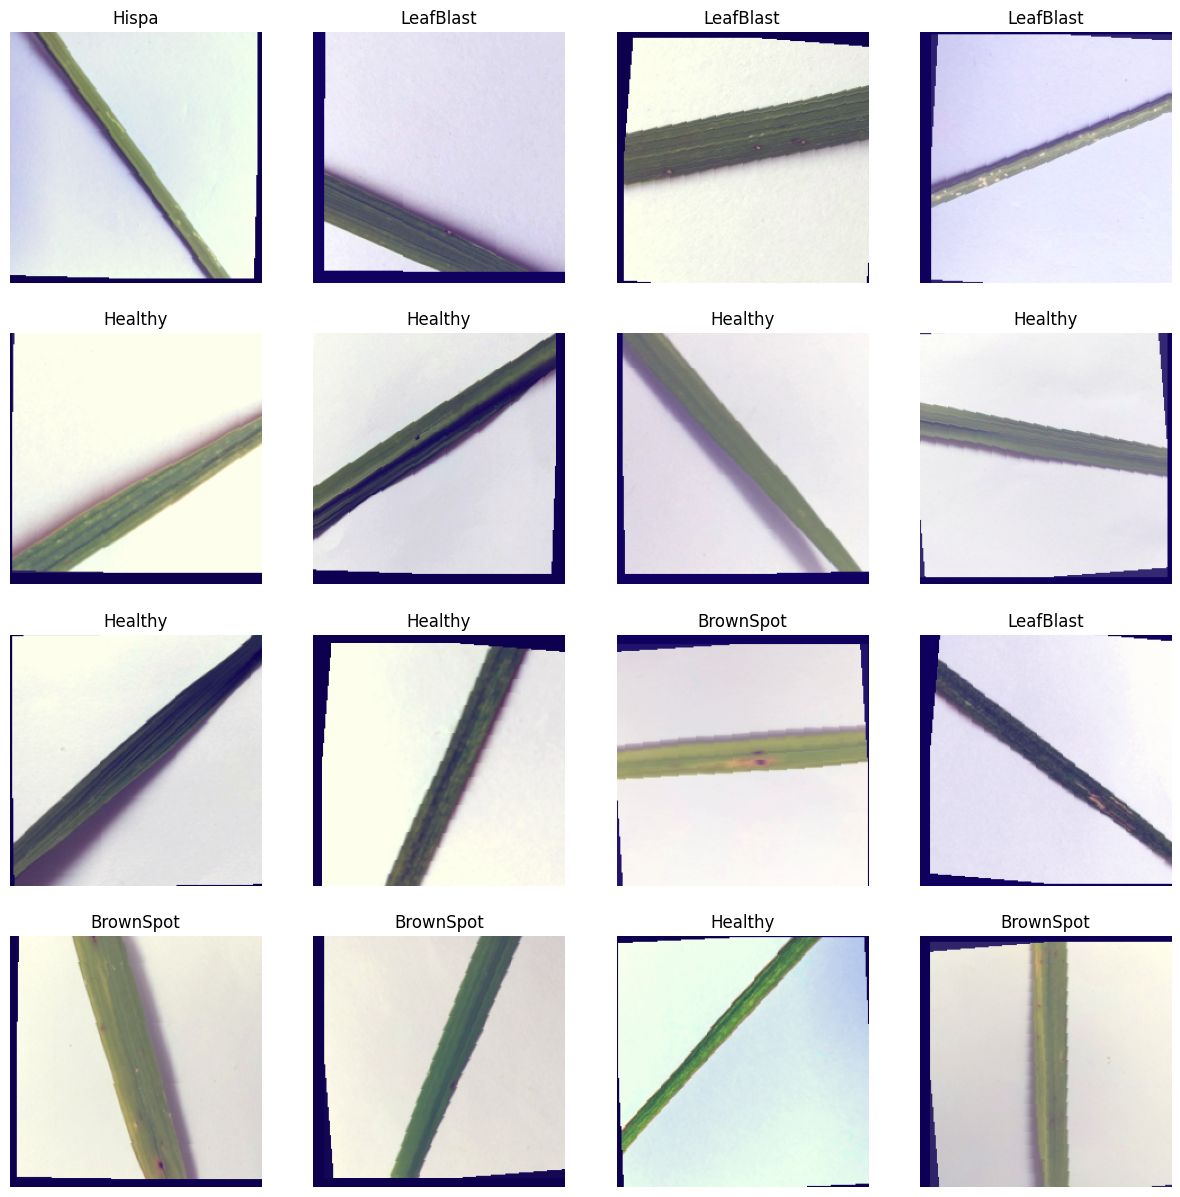

In [ ]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:
pretrained_model = models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Lấy số lượng đặc trưng đầu vào của lớp fully connected từ pretrained_model
IN_FEATURES = pretrained_model.fc.in_features
# Xác định số lượng lớp đầu ra dựa trên số lớp trong test_data
OUTPUT_DIM = len(test_data.classes)

# Tạo lớp fully connected mới với số đặc trưng đầu vào và đầu ra mong muốn
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)     # 2048 => 4

In [ ]:
# Thay fc và sử dụng trực tiếp pretrained_model
pretrained_model.fc = fc

In [ ]:
model = pretrained_model

In [ ]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
# Đếm số lượng tham số được huấn luyện
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Mô hình có {count_parameters(model):,} tham số được huấn luyện.')

Mô hình có 23,516,228 tham số được huấn luyện.


In [ ]:
# Định nghĩa learning rate đầu
START_LR = 1e-7

# Thiết lập optimizer, device, criterion
optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Lớp LRFinder: Tìm learning rate tối ưu bằng cách thử nghiệm
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        # Khởi tạo với mô hình, optimizer, hàm mất mát và thiết bị
        self.optimizer = optimizer      # Adam
        self.model = model              # ResNet50 pretrain
        self.criterion = criterion      # CrossEntropyLoss
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    # Hàm thử nghiệm learning rate trong khoảng từ nhỏ đến end_lr
    def range_test(self, iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th = 5):

        lrs = []        # Danh sách learning rates đã thử
        losses = []     # Danh sách losses
        best_loss = float('inf')    # Loss nhỏ nhất ban đầu là vô cực

        # Khởi tạo scheduler tăng learning rate theo hàm mũ
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    # Hàm huấn luyện 1 batch
    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

# Lớp scheduler tăng learning rate theo hàm mũ
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
# Chạy LRFinder để tìm learning rate tối ưu
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


<ipython-input-32-1896c9f1957f>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('init_params.pt'))


In [ ]:
# Định nghĩa hàm vẽ biểu đồ LRFinder
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

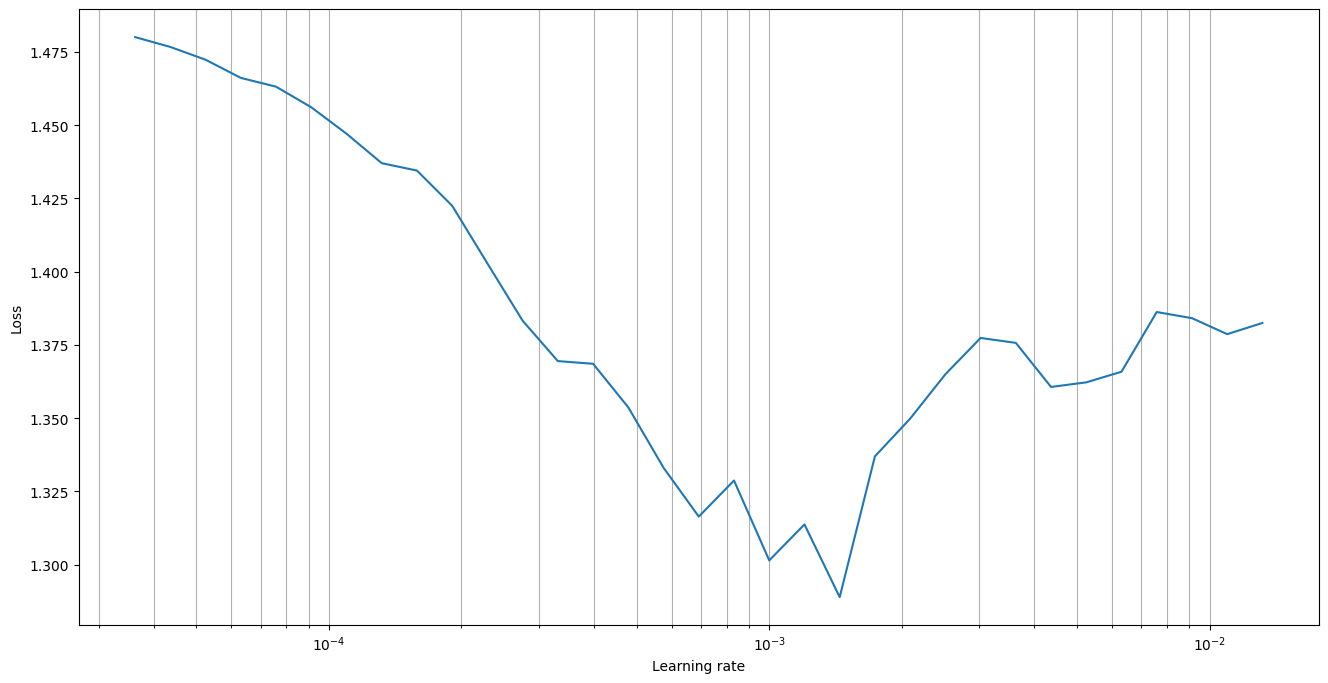

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [ ]:
# Chọn learning rate và thiết lập optimizer với differential learning rates
FOUND_LR = 1e-3

params = [
    {"params": model.conv1.parameters(), "lr": FOUND_LR / 10},
    {"params": model.bn1.parameters(), "lr": FOUND_LR / 10},
    {"params": model.layer1.parameters(), "lr": FOUND_LR / 8},
    {"params": model.layer2.parameters(), "lr": FOUND_LR / 6},
    {"params": model.layer3.parameters(), "lr": FOUND_LR / 4},
    {"params": model.layer4.parameters(), "lr": FOUND_LR / 2},
    {"params": model.fc.parameters()},
]


optimizer = optim.Adam(params, lr=FOUND_LR)

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p["lr"] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LRS, total_steps=TOTAL_STEPS)

In [ ]:
# Định nghĩa hàm tính top-k accuracy
def calculate_topk_accuracy(y_pred, y, k = 4):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
# Định nghĩa hàm huấn luyện
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# Định nghĩa hàm đánh giá
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# Định nghĩa hàm tính thời gian epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnest50.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 5m 16s
	Train Loss: 1.088 | Train Acc @1:  54.92% | Train Acc @5: 100.00%
	Valid Loss: 0.790 | Valid Acc @1:  71.47% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 4m 46s
	Train Loss: 0.794 | Train Acc @1:  70.23% | Train Acc @5: 100.00%
	Valid Loss: 0.766 | Valid Acc @1:  71.32% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 4m 40s
	Train Loss: 0.756 | Train Acc @1:  72.18% | Train Acc @5: 100.00%
	Valid Loss: 0.731 | Valid Acc @1:  70.37% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 4m 45s
	Train Loss: 0.730 | Train Acc @1:  73.20% | Train Acc @5: 100.00%
	Valid Loss: 0.676 | Valid Acc @1:  75.59% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 4m 41s
	Train Loss: 0.740 | Train Acc @1:  73.58% | Train Acc @5: 100.00%
	Valid Loss: 0.736 | Valid Acc @1:  73.75% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 4m 36s
	Train Loss: 0.690 | Train Acc @1:  75.57% | Train Acc @5: 100.00%
	Valid Loss: 0.735 | Valid Acc @1:  76.40% | Valid Acc @5: 100.00%
Epoch: 07 

In [ ]:
# Đánh giá trên tập test
model.load_state_dict(torch.load('resnest50.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

<ipython-input-32-b59275181665>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tut5-model.pt'))


Test Loss: 0.461 | Test Acc @1:  85.35% | Test Acc @5: 100.00%


In [ ]:
# Hàm tính và in precision, recall, f1-score cho từng lớp
def calculate_class_metrics(model, iterator, device):
  """
  Tính toán precision, recall, f1 score cho từng lớp.

  Args:
    model: Mô hình.
    iterator: DataLoader.
    device: Thiết bị (CPU hoặc GPU).

  Returns:
    Một dictionary chứa precision, recall, f1 score cho từng lớp.
  """

  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      _, predicted = torch.max(y_pred, 1)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

  precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
  class_metrics = {}
  for i in range(len(test_data.classes)):
    class_metrics[test_data.classes[i]] = {
        'precision': precision[i],
        'recall': recall[i],
        'f1_score': f1_score[i]
    }
  return class_metrics

# Tính toán chỉ số cho từng lớp
class_metrics = calculate_class_metrics(model, test_iterator, device)

# In ra kết quả
for class_name, metrics in class_metrics.items():
  print(f"Class: {class_name}")
  print(f"\tPrecision: {metrics['precision']:.3f}")
  print(f"\tRecall: {metrics['recall']:.3f}")
  print(f"\tF1 Score: {metrics['f1_score']:.3f}")


Class: BrownSpot
	Precision: 0.917
	Recall: 0.838
	F1 Score: 0.876
Class: Healthy
	Precision: 0.842
	Recall: 0.909
	F1 Score: 0.874
Class: Hispa
	Precision: 0.752
	Recall: 0.679
	F1 Score: 0.714
Class: LeafBlast
	Precision: 0.908
	Recall: 0.885
	F1 Score: 0.896


In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

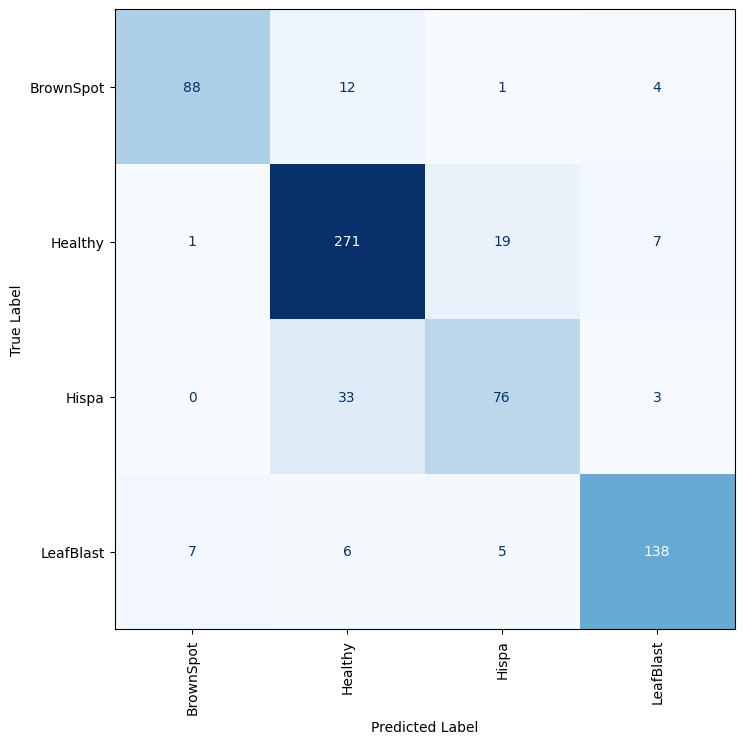

In [ ]:
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

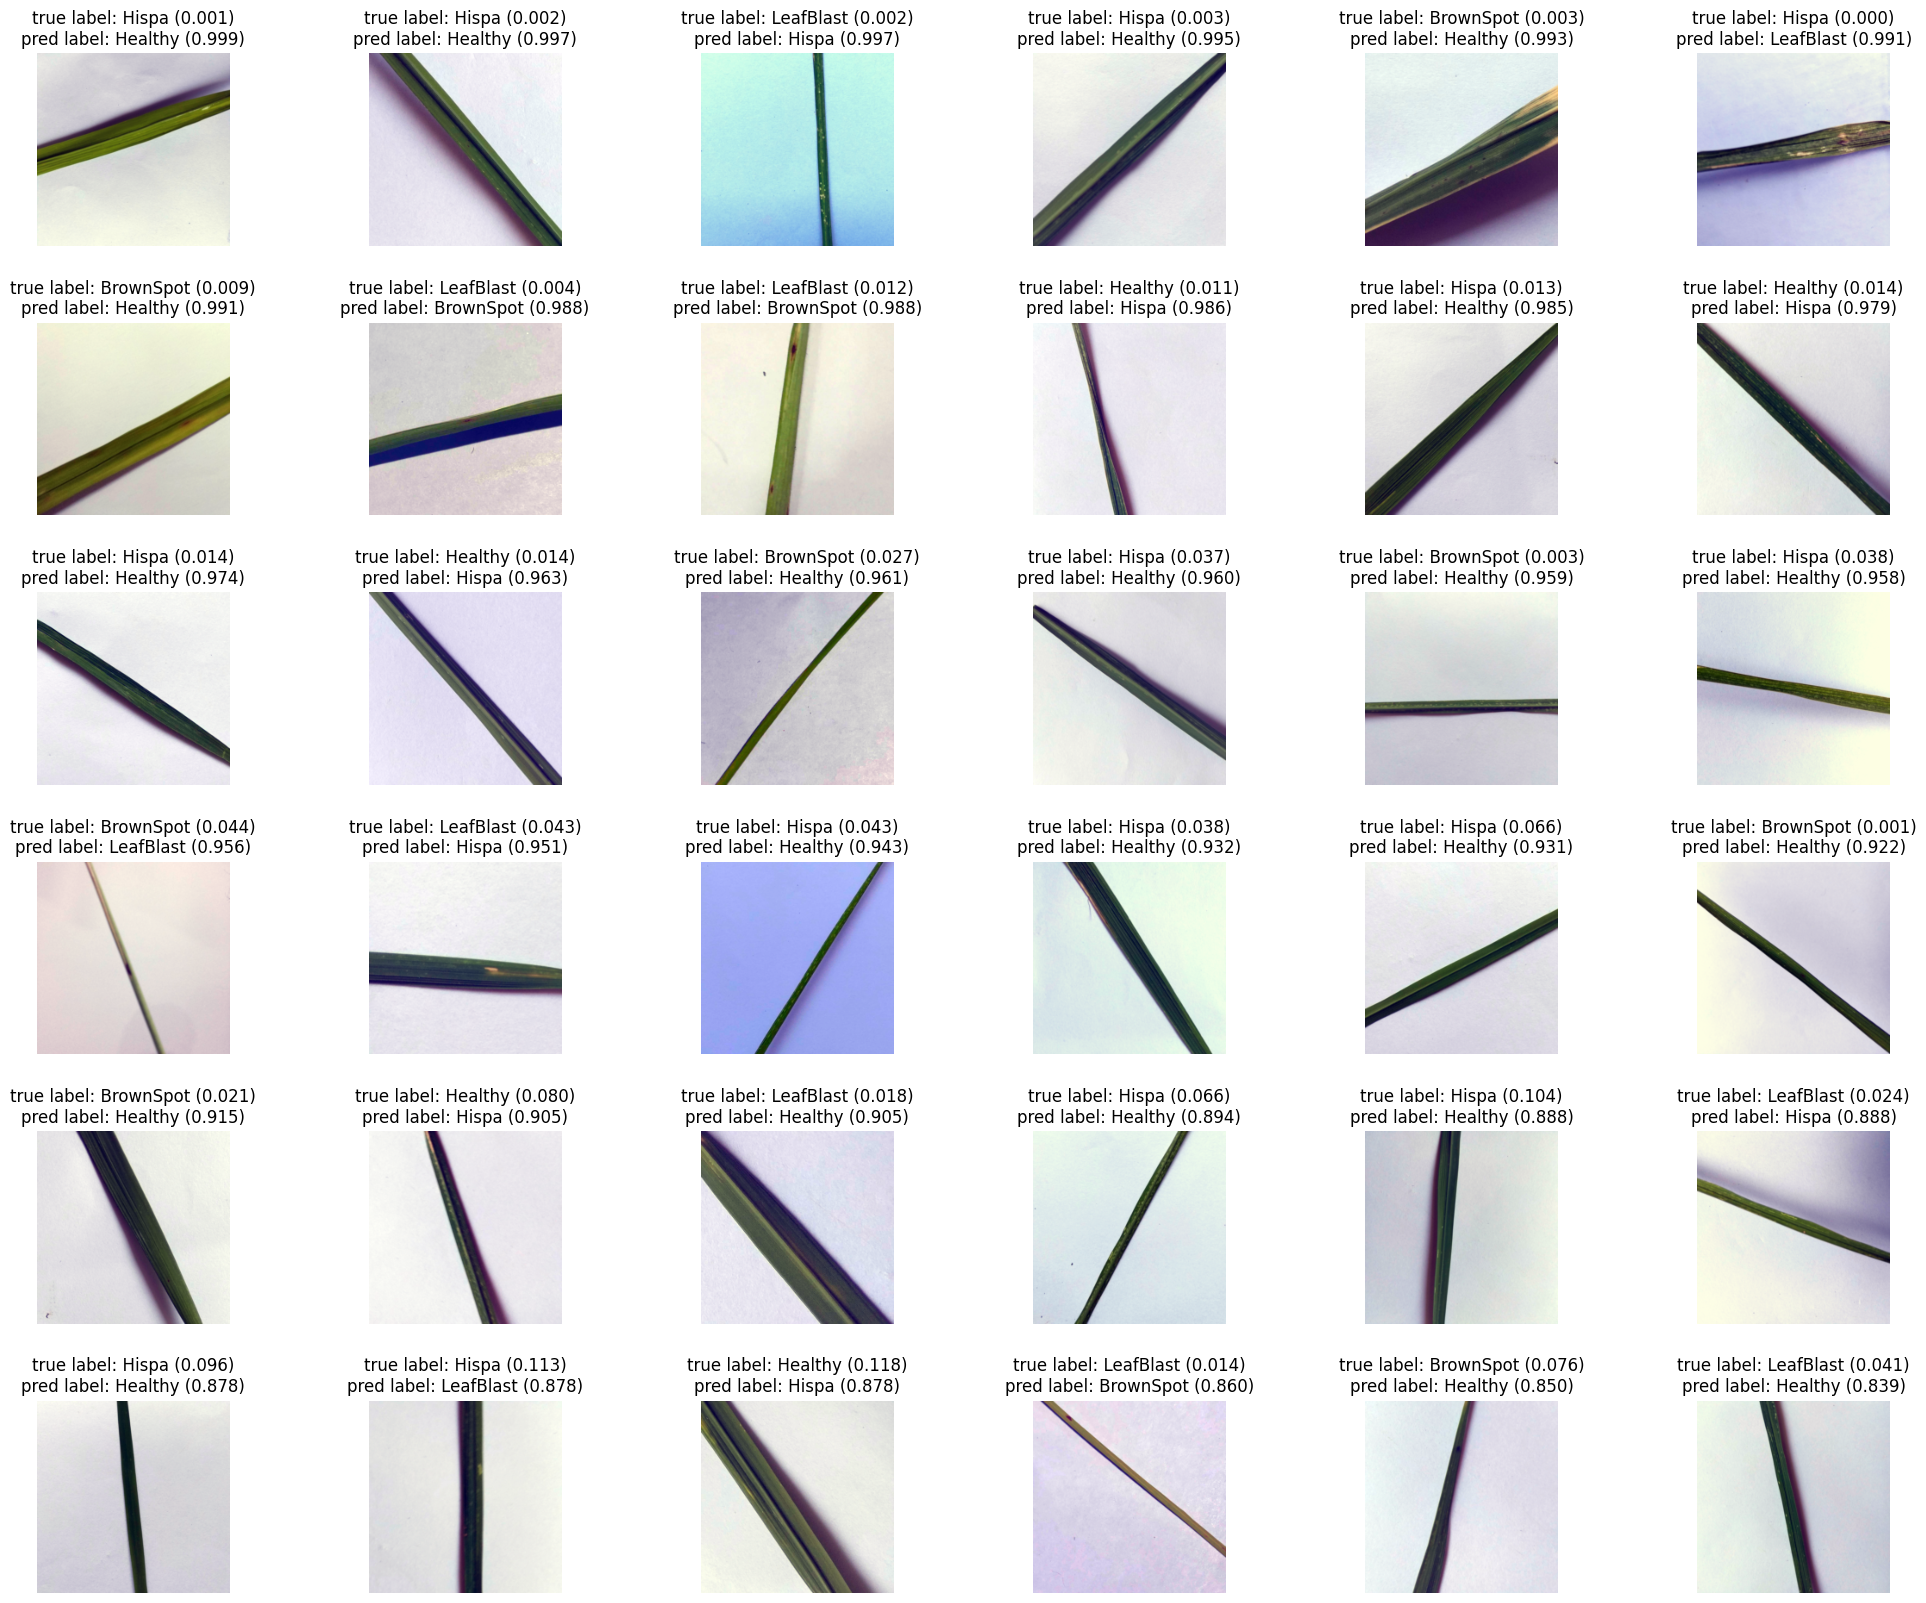

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_iterator)

In [ ]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

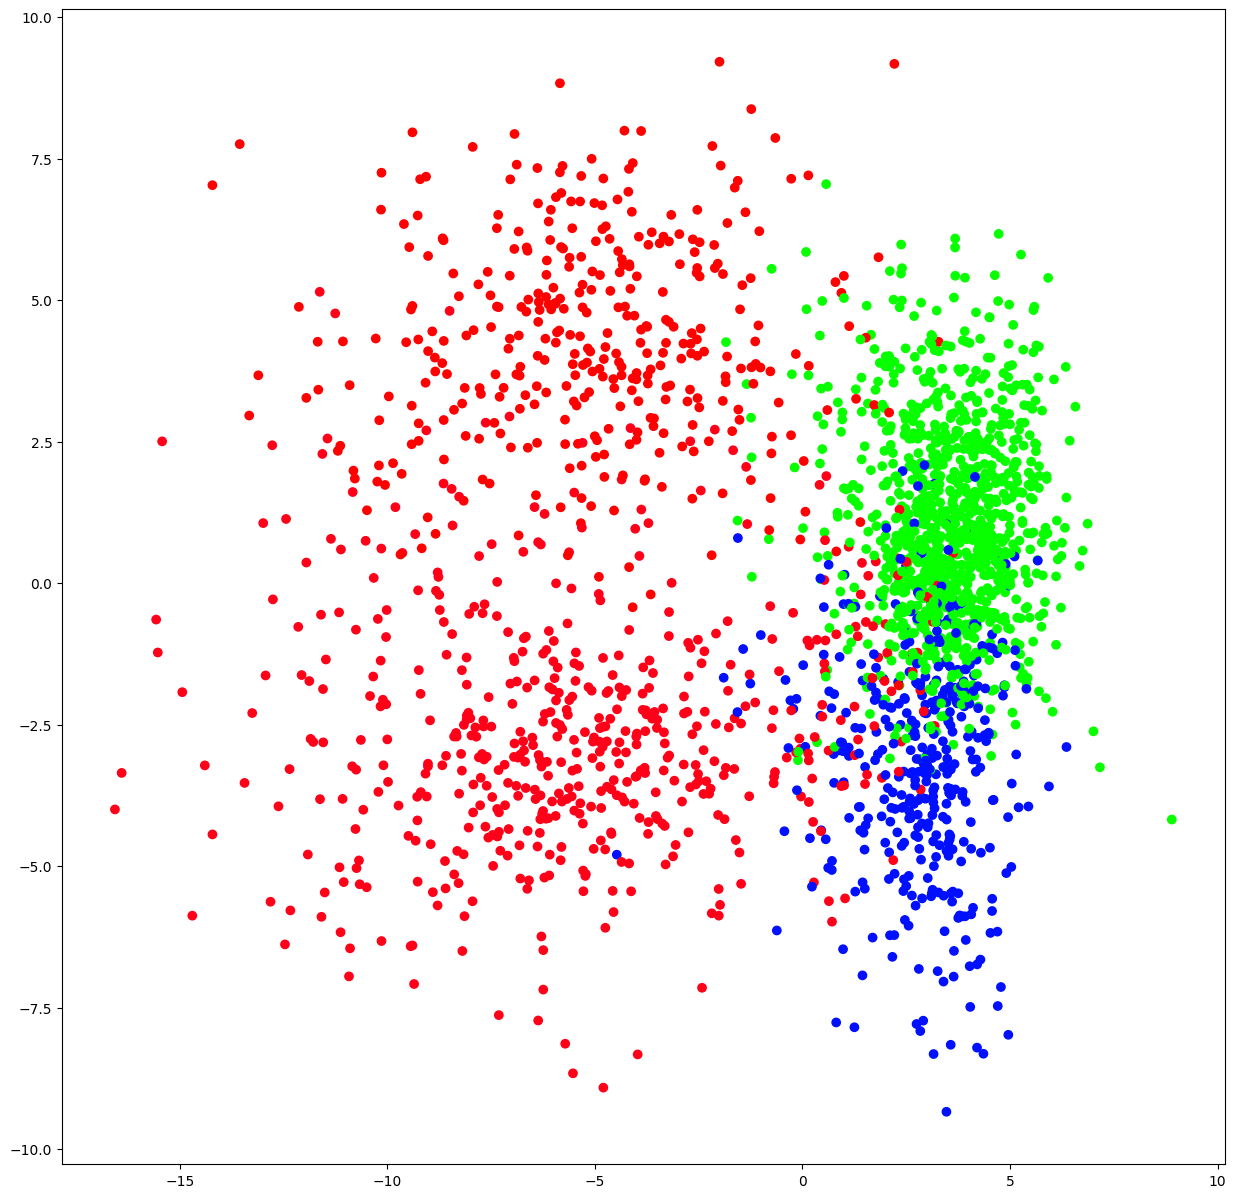

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

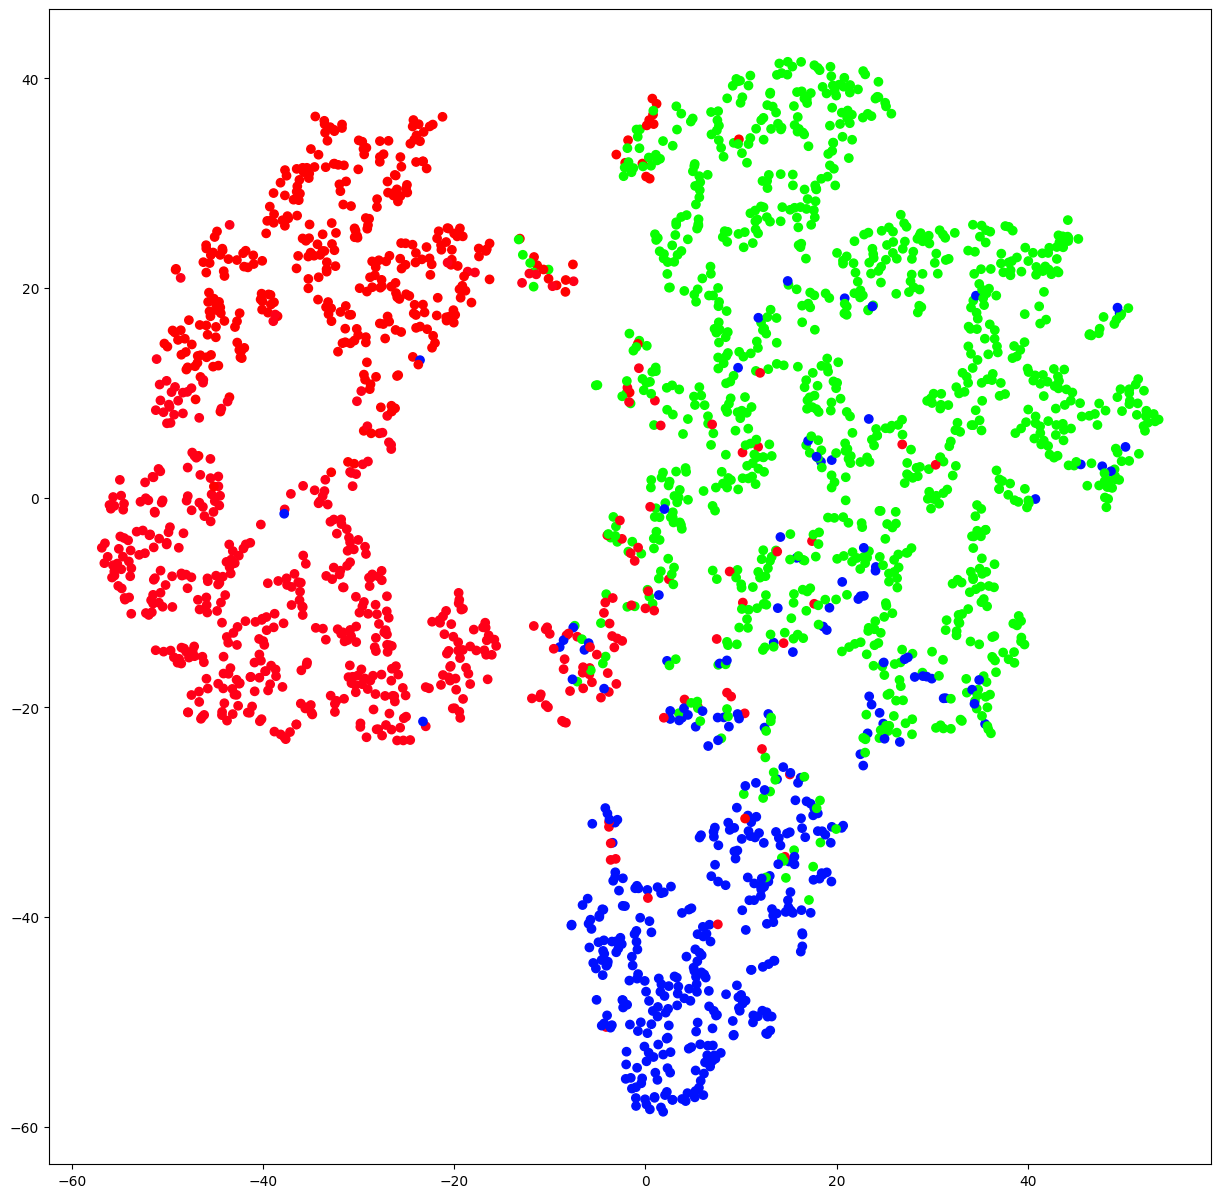

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

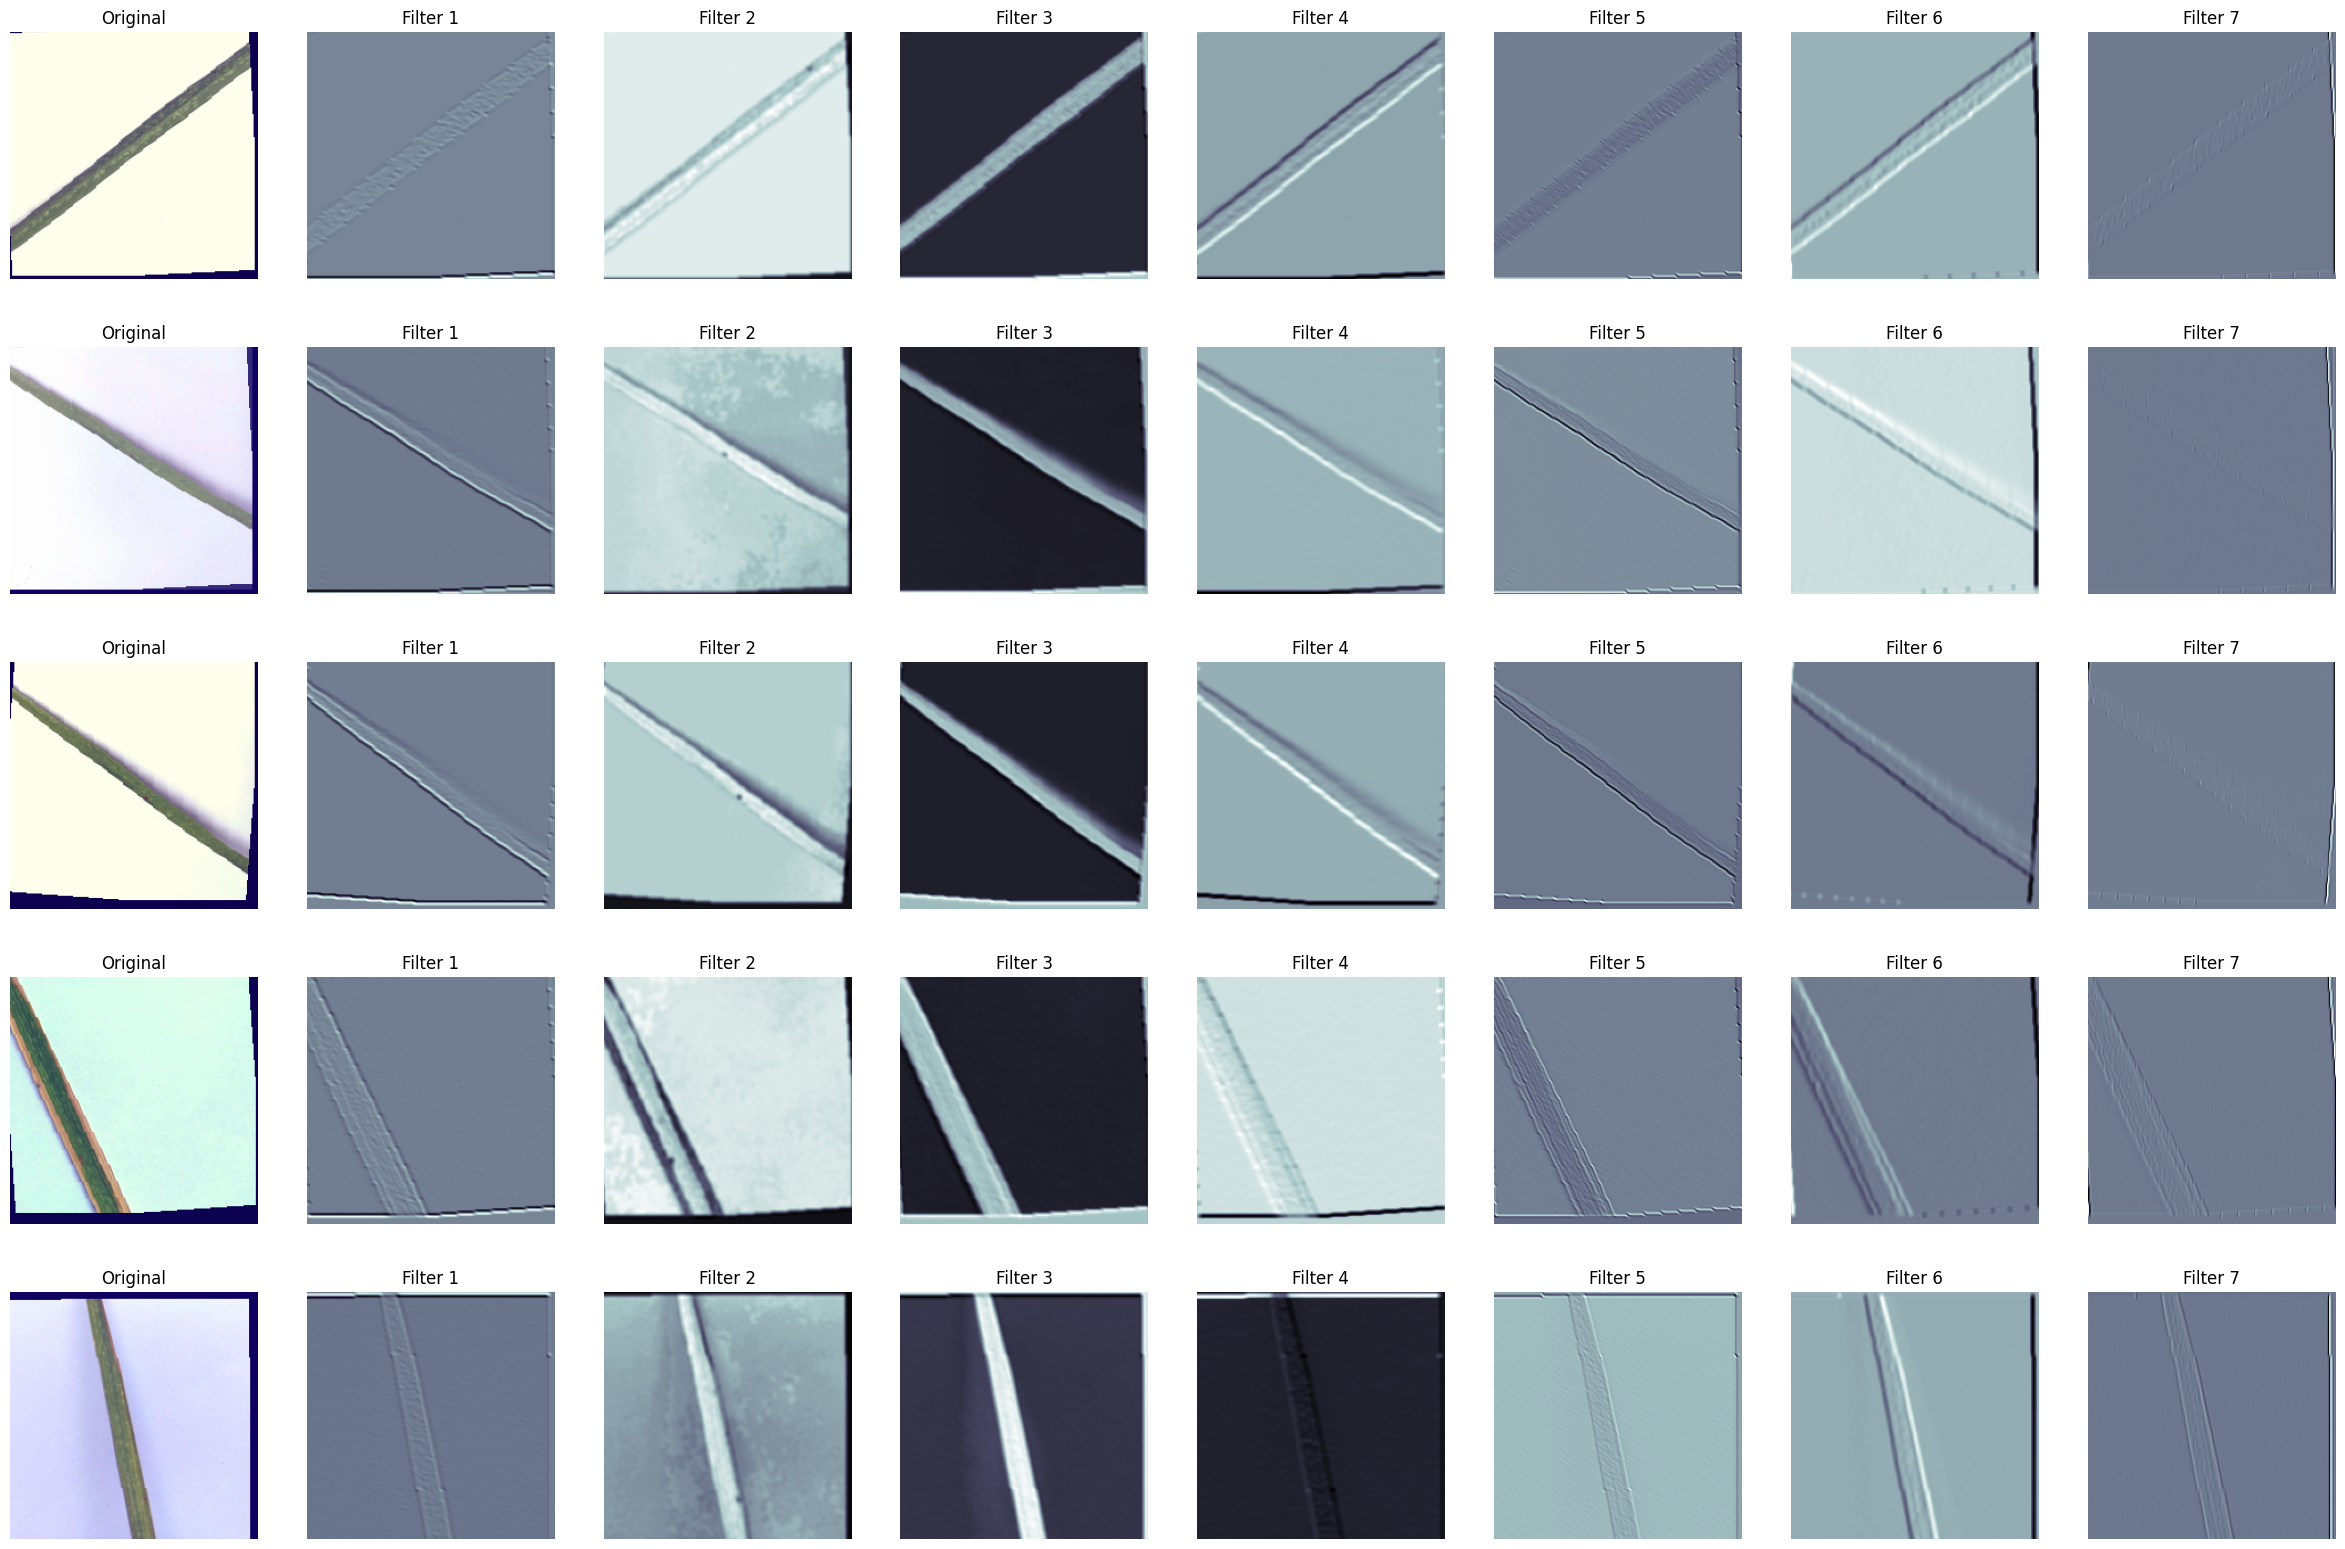

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

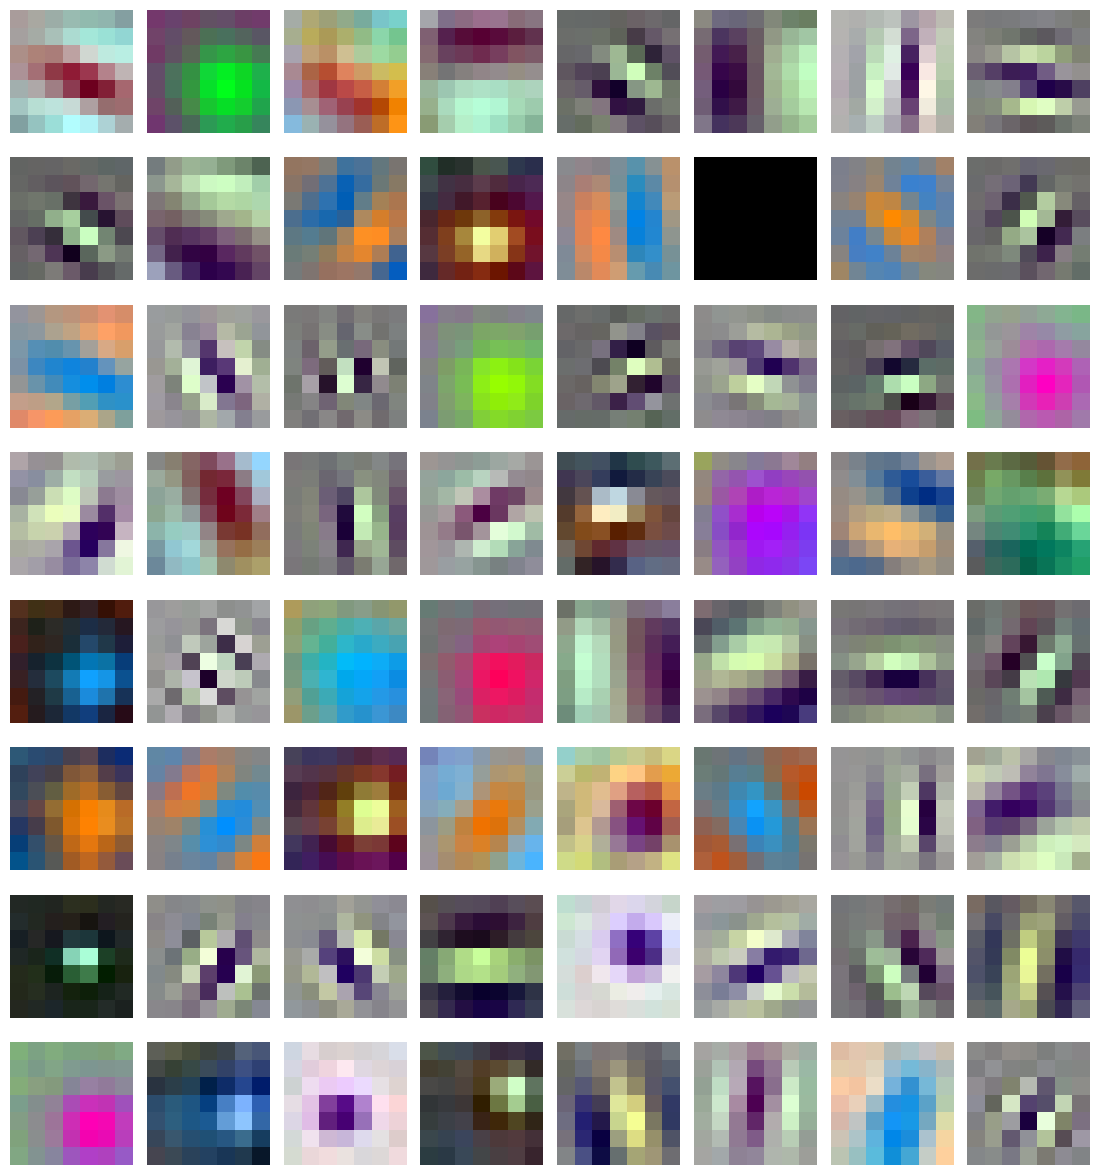

In [ ]:
plot_filters(filters)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu
epochs = list(range(1, 21))
train_loss = [1.088, 0.794, 0.756, 0.730, 0.740, 0.690, 0.660, 0.604, 0.575, 0.534,
              0.501, 0.461, 0.450, 0.405, 0.367, 0.324, 0.289, 0.261, 0.270, 0.246]
train_acc = [54.92, 70.23, 72.18, 73.20, 73.58, 75.57, 76.46, 78.90, 79.75, 81.27,
             82.42, 83.90, 84.22, 85.25, 87.42, 88.54, 89.94, 90.34, 90.08, 91.17]
valid_loss = [0.790, 0.766, 0.731, 0.676, 0.736, 0.735, 0.531, 0.565, 0.524, 0.498,
              0.473, 0.496, 0.443, 0.478, 0.460, 0.410, 0.394, 0.425, 0.402, 0.398]
valid_acc = [71.47, 71.32, 70.37, 75.59, 73.75, 76.40, 80.81, 82.65, 81.03, 81.69,
             83.75, 82.57, 84.93, 84.85, 84.41, 86.10, 85.81, 86.10, 86.99, 87.57]

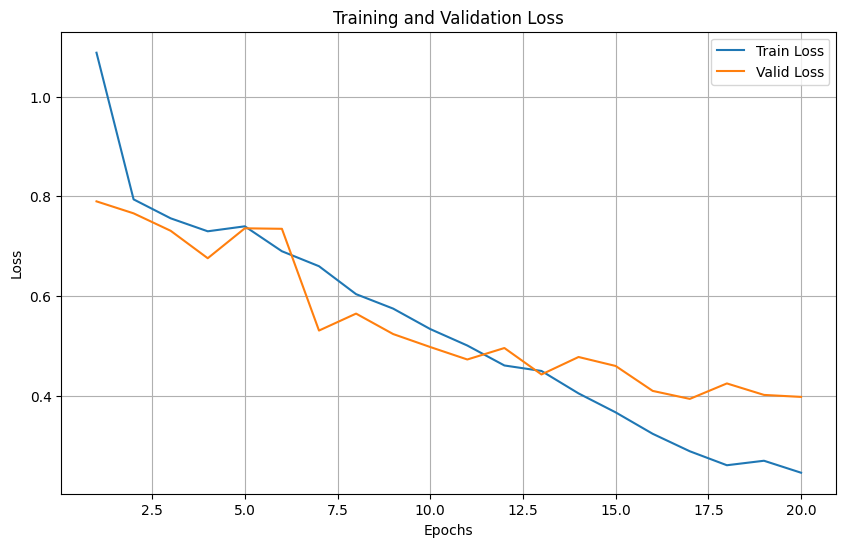

In [ ]:
# 1. Loss plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

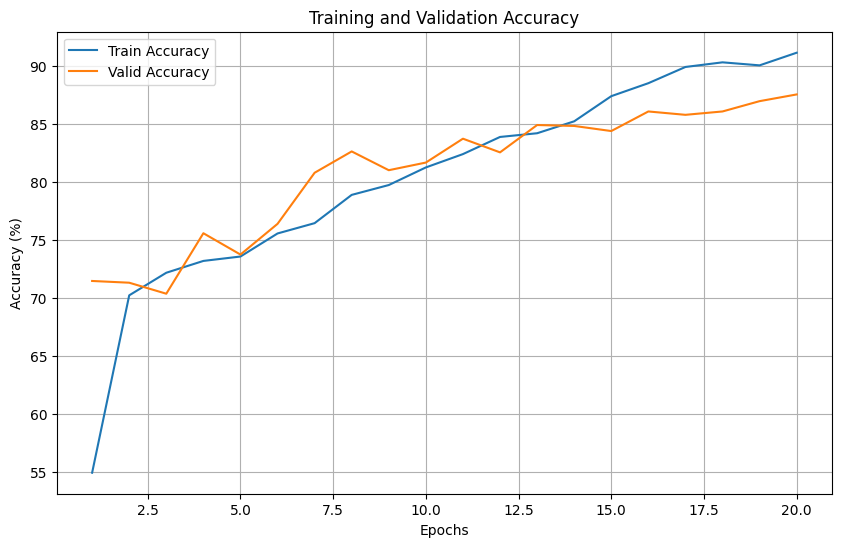

In [ ]:
# 2. Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, valid_acc, label='Valid Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

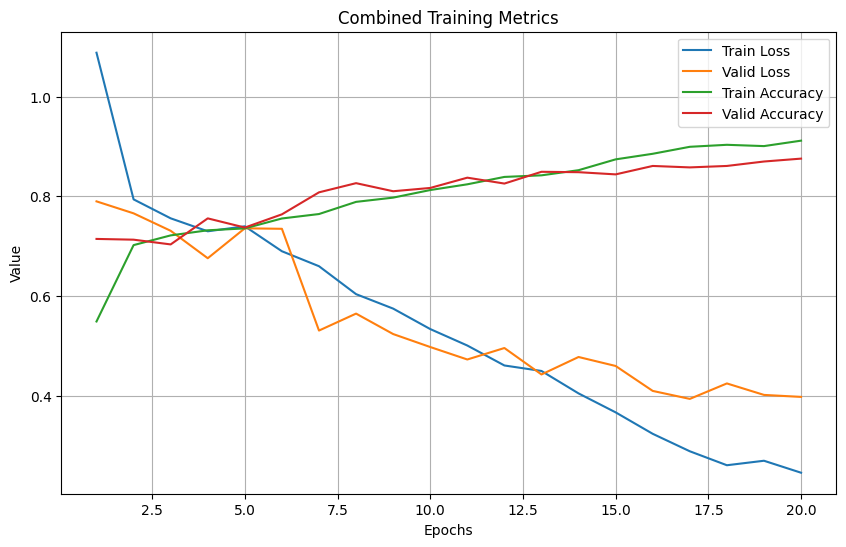

In [ ]:
# 3. Combined plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Valid Loss')
plt.plot(epochs, np.array(train_acc)/100, label='Train Accuracy')
plt.plot(epochs, np.array(valid_acc)/100, label='Valid Accuracy')
plt.title('Combined Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()